In [396]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.constants import N_A
import math
import seaborn as sns

In [397]:
def selectivity_model(t, z, Atot, r1tot, r2tot, s1tot, k1, k2, 
                      q1, q2, p1, koff, qoff, poff):
    
    A00 = Atot - z[0] - z[1] - z[2] - z[3]
    r1 = r1tot - z[0] - z[2]
    r2 = r2tot - z[1] - z[2]
    s1 = s1tot - z[3]

    dA10 = k1*A00*r1 - koff*z[0] - q2*z[0]*r2 + qoff*z[2]
    dA01 = q1*A00*r2 - qoff*z[1] - k2*z[1]*r1 + koff*z[2]
    dA11 = q2*z[0]*r2 + k2*z[1]*r1 - (qoff + koff)*z[2]
    dA10_nt = p1*A00*s1 - poff*z[3]

    dz = [dA10, dA01, dA11, dA10_nt]

    return dz

In [398]:
kon = 10**(5)
koff = 10**(-4)
pon = kon
poff = koff

qon = 1e5
qoff = 1e-4

Target_cell_number = 2e5
Non_target_cell_number = 2e7
well_size = 125e-6
t_end = 60*60*1000
t = np.geomspace(1e-5, t_end, 200)
t_span = [1e-10, t_end]
z0 = np.asarray([0, 0, 0, 0])
tumour_cell_radius = 8e-6
sigma = well_size*N_A

r1tot = 1e3
r1tot = r1tot*Target_cell_number
r2tot = 1e6
r2tot = r2tot*Target_cell_number
s1tot = 1e3
s1tot = s1tot*Non_target_cell_number

k1 = kon/sigma
p1 = k1
q1 = qon/sigma

D1 = 1e-14
D2 = 1e-14
k2 = D1/(2*math.pi*(tumour_cell_radius**2)*Target_cell_number)
q2 = D2/(2*math.pi*(tumour_cell_radius**2)*Target_cell_number)

Ainit = 1e-5
Atot = Ainit*sigma
sns.set_theme()

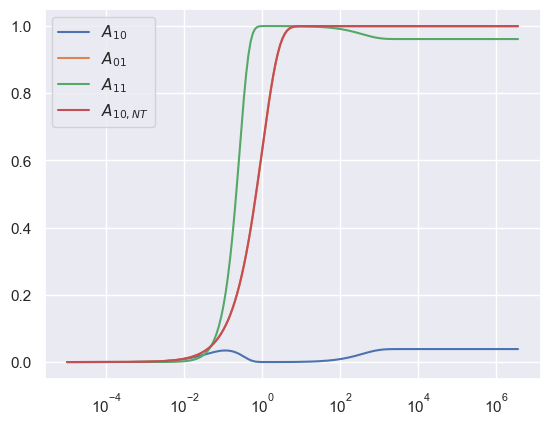

In [399]:
z = solve_ivp(selectivity_model, t_span, z0, method='Radau', t_eval=t, args=(Atot, r1tot, r2tot, s1tot, k1, k2, 
                      q1, q2, p1, koff, qoff, poff))

plt.plot(t, z.y[0]/r1tot, label=r'$A_{10}$')
plt.plot(t, z.y[1]/r2tot, label=r'$A_{01}$')
plt.plot(t, z.y[2]/r1tot, label=r'$A_{11}$')
plt.plot(t, z.y[3]/s1tot, label=r'$A_{10, NT}$')

plt.xscale('log')
plt.legend(loc='best')
plt.show()

In [400]:
A0s = np.geomspace(1e-13, 5e-5, 200)

r1tots = [1e3, 1e4, 1e5, 1e6, 1e7]
target_props = []
r2tot=1e6*Target_cell_number
kon = 10**(3.5)
koff = 10**(-3.5)
pon = kon
poff = koff

qon = 1e5
qoff = 1e-4
for r1tot in r1tots:
    s1tot = r1tot
    r1tot = r1tot*Target_cell_number
    s1tot = s1tot*Non_target_cell_number
    A10_array = np.zeros_like(A0s)
    A01_array = np.zeros_like(A0s)
    A11_array = np.zeros_like(A0s)
    A10_nt_array = np.zeros_like(A0s)
    for i, Ainit in enumerate(A0s):
        Atot = Ainit*sigma
        z = solve_ivp(selectivity_model, t_span, z0, method='Radau', t_eval=t, args=(Atot, r1tot, r2tot, s1tot, k1, k2, 
                        q1, q2, p1, koff, qoff, poff))
    
        A10 = z.y[0]
        A01 = z.y[1]
        A11 = z.y[2]
        A10_nt = z.y[3]

        A10_array[i] = A10[-1]
        A01_array[i] = A01[-1]
        A11_array[i] = A11[-1]
        A10_nt_array[i] = A10_nt[-1]
    
    target_prop = ((A10_array + A11_array + A01_array))/(A10_array + A11_array + A01_array+ A10_nt_array)
    target_props.append(target_prop)
  

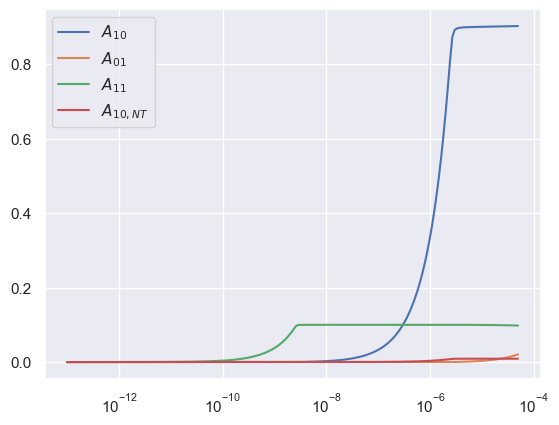

In [401]:
plt.plot(A0s, A10_array/r1tot, label = r'$A_{10}$')
plt.plot(A0s, A01_array/r2tot, label = r'$A_{01}$')
plt.plot(A0s, A11_array/r1tot, label = r'$A_{11}$')
plt.plot(A0s, A10_array/s1tot, label = r'$A_{10, NT}$')
plt.legend(loc='best')
plt.xscale('log')

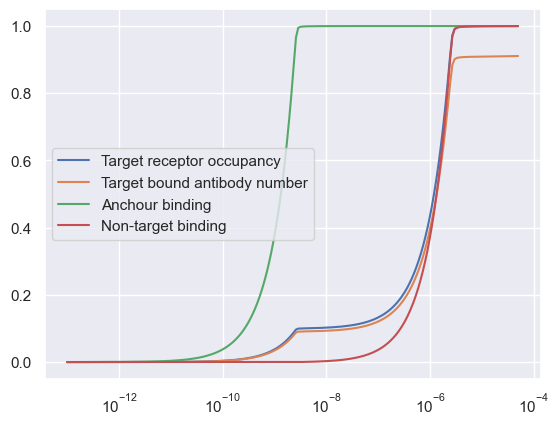

In [402]:
plt.plot(A0s, (A10_array + A11_array)/r1tot, label='Target receptor occupancy')
plt.plot(A0s, (A10_array + A11_array + A01_array)/(r1tot + r2tot), label='Target bound antibody number')
plt.plot(A0s, (A01_array + A11_array)/r2tot, label='Anchour binding')
plt.plot(A0s, A10_nt_array/s1tot, label='Non-target binding')
plt.legend(loc='best')
plt.xscale('log')
plt.show()

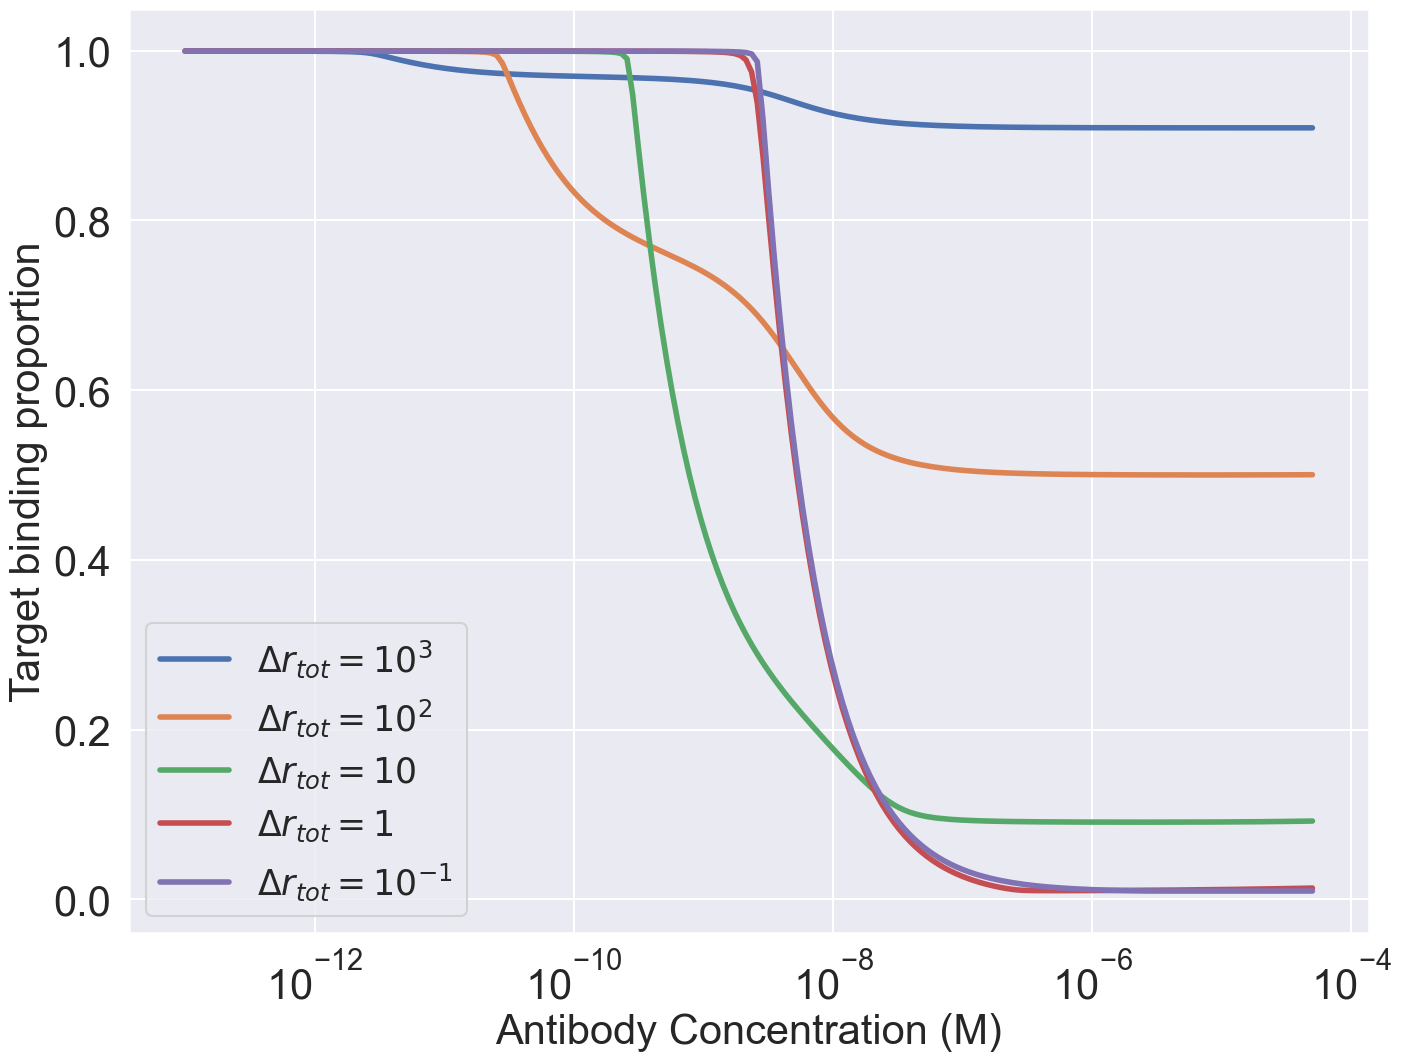

In [403]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(16, 12))
labels=[r'$\Delta r_{tot}=10^3$', r'$\Delta r_{tot}=10^2$', r'$\Delta r_{tot}=10$', r'$\Delta r_{tot}=1$', r'$\Delta r_{tot}=10^{-1}$']
for i in range(len(r1tots)):
    ax.semilogx(A0s, target_props[i], label=labels[i], lw=4)

ax.tick_params(labelsize=30)
plt.legend(loc='best', fontsize=25)
plt.xlabel('Antibody Concentration (M)', fontsize=30)
plt.ylabel('Target binding proportion', fontsize=30)
#plt.ylim((1, 1e7))
plt.show()

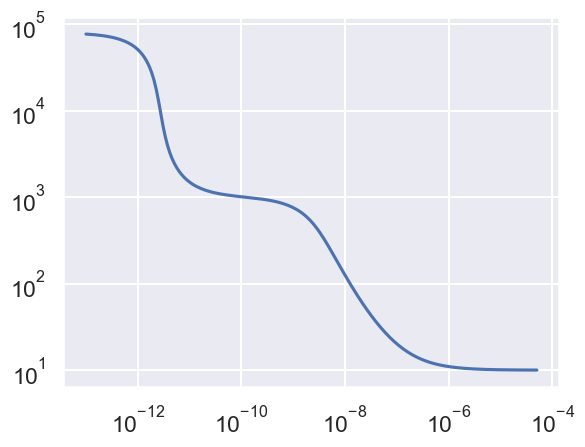

In [404]:
kon = 10**(3.5)
koff = 10**(-3.5)
pon = kon
poff = koff

qon = 1e5
qoff = 1e-4

Target_cell_number = 2e5
Non_target_cell_number = 2e7
well_size = 125e-6
t_end = 60*60*1000
t = np.geomspace(1e-5, t_end, 200)
t_span = [1e-10, t_end]
z0 = np.asarray([0, 0, 0, 0])
tumour_cell_radius = 8e-6
sigma = well_size*N_A

r1tot = 1e3
r1tot = r1tot*Target_cell_number
r2tot = 1e6
r2tot = r2tot*Target_cell_number
s1tot = 1e3
s1tot = s1tot*Non_target_cell_number

k1 = kon/sigma
p1 = k1
q1 = qon/sigma

D1 = 1e-14
D2 = 1e-14
k2 = D1/(2*math.pi*(tumour_cell_radius**2)*Target_cell_number)
q2 = D2/(2*math.pi*(tumour_cell_radius**2)*Target_cell_number)

for i, Ainit in enumerate(A0s):
        Atot = Ainit*sigma
        z = solve_ivp(selectivity_model, t_span, z0, method='Radau', t_eval=t, args=(Atot, r1tot, r2tot, s1tot, k1, k2, 
                        q1, q2, p1, koff, qoff, poff))
    
        A10 = z.y[0]
        A01 = z.y[1]
        A11 = z.y[2]
        A10_nt = z.y[3]

        A10_array[i] = A10[-1]
        A01_array[i] = A01[-1]
        A11_array[i] = A11[-1]
        A10_nt_array[i] = A10_nt[-1]

target_prop = ((A10_array + A11_array + A01_array))/(A10_nt_array)
plt.loglog(A0s, target_prop)

In [405]:
Ainit = 1e-8
Atot = Ainit*sigma
r1tots = np.geomspace(1e3, 1e6, 100)
r2tots = np.geomspace(1e3, 1e6, 100)
Y = np.zeros((len(r1tots), len(r2tots)))

for i, r1tot in enumerate(r1tots):
    r1tot = r1tot*Target_cell_number
    s1tot = r1tot*(Non_target_cell_number/Target_cell_number)
    for j, r2tot in enumerate(np.flip(r2tots)):
        r2tot = r2tot*Target_cell_number
        z = solve_ivp(selectivity_model, t_span, z0, method='Radau', t_eval=t, args=(Atot, r1tot, r2tot, s1tot, k1, k2, 
                      q1, q2, p1, koff, qoff, poff))
        
        A10 = z.y[0]
        A01 = z.y[1]
        A11 = z.y[2]
        A10_nt = z.y[3]
        A10_st = A10[-1]
        A01_st = A01[-1]
        A11_st = A11[-1]
        A10_nt_st = A10_nt[-1]

        selectivity = ((A10_st + A11_st + A01_st))/(A10_nt_st)
        Y[i, j] = selectivity

KeyboardInterrupt: 

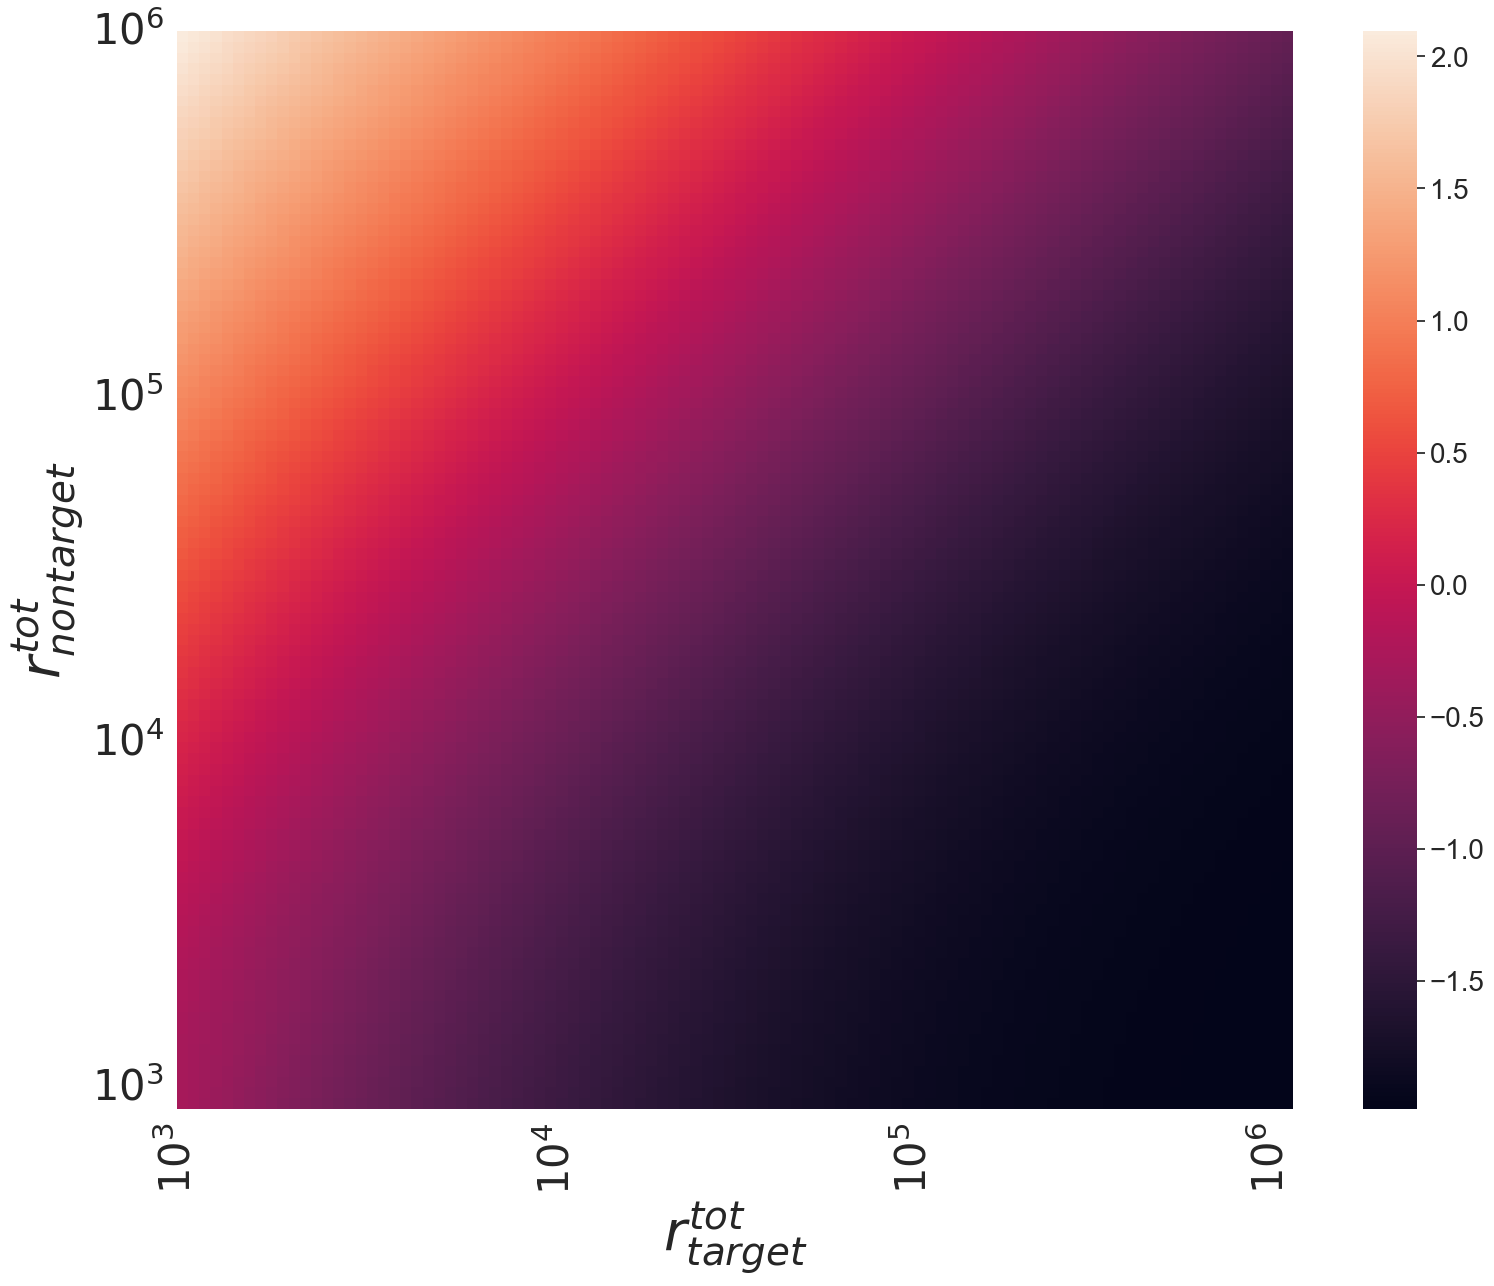

In [ ]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(18, 14))
line = sns.heatmap(np.log10(Y), xticklabels=True, yticklabels=True, ax=ax) 
ax.set_yticks([0, 17*2, 33*2, 49*2])
ax.set_xticks([0, 17*2, 33*2, 49*2])
ax.set_yticklabels(np.flip([r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$']), fontsize=30)
ax.set_xticklabels([r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$'], fontsize=30)
ax.set_xlabel(r'$r^{tot}_{target}$', fontsize=40)
ax.set_ylabel(r'$r^{tot}_{nontarget}$', fontsize=40)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)